<a href="https://colab.research.google.com/github/naraphattul/229352-StatisticalLearning/blob/main/660510769_Lab02_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #2

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# For Fashion-MNIST
from tensorflow.keras.datasets import fashion_mnist

# For 20 Newsgroups
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## Part 1: Marketing Campaign Dataset - Manual Data Preprocessing & Logistic Regression

### Load the Marketing Campaign Dataset ([Data Information](https://archive.ics.uci.edu/dataset/222/bank+marketing))

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (`'yes'`) or not (`'no'`) subscribed.

In [31]:
# URL for the raw Bank Marketing dataset CSV
bank_url = 'https://raw.githubusercontent.com/donlap/ds352-labs/main/bank.csv'

# Load the dataset
# - sep=';' is crucial as it's semicolon-separated
# - na_values=['unknown'] converts 'unknown' strings to NaN
df = pd.read_csv(bank_url, sep=';', na_values=['unknown'])
df = df.drop(["emp.var.rate", "cons.price.idx", "cons.conf.idx",	"euribor3m", "nr.employed"], axis=1)
print("Shape of the dataset:", df.shape)
df.head()

Shape of the dataset: (41188, 16)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,no


### Data Exploration

In [46]:
# Check for missing values
print("--- Missing Values Count ---")
print(df.isnull().sum())

--- Missing Values Count ---
age                0
job              330
marital           80
education       1731
default         8597
housing          990
loan             990
contact            0
month              0
day_of_week        0
campaign           0
pdays              0
previous           0
poutcome           0
y              36548
dtype: int64


In [47]:
# Check unique values and counts for categorical columns
print("--- Unique Values for Categorical Columns ---")
for col in df.select_dtypes(include='object').columns:
    print(f"\n'{col}' unique values:")
    print(df[col].value_counts(dropna=False)) # Include NaN counts

--- Unique Values for Categorical Columns ---

'job' unique values:
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
NaN                330
Name: count, dtype: int64

'marital' unique values:
marital
married     24928
single      11568
divorced     4612
NaN            80
Name: count, dtype: int64

'education' unique values:
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
NaN                     1731
illiterate                18
Name: count, dtype: int64

'default' unique values:
default
no     32588
NaN     8597
yes        3
Name: count, dtype: int64

'housing' unique values:
housing
yes    21576
no     18622
NaN      990
Name: count, dtype: int64


### Data Preprocessing

In [34]:
# Map target variable 'y' to 0 (no) and 1 (yes)
df['y'] = df['y'].map({'yes': 1, 'no.': 0})

# Calculate class statistics
print(df['y'].describe())

# Drop 'duration' due to data leakage
df = df.drop('duration', axis=1)

# Define features (X) and target (y)
y = df['y']
X = df.drop('y', axis=1) #drop ตัวแปรตามออกมา (ดึง y ออกมา)

# Split the data BEFORE any transformations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # test set 70/30

# Print data shape
print(X_train.shape, X_test.shape)

count    4640.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: y, dtype: float64
(28831, 14) (12357, 14)


We will apply `StandardScaler()`, `OrdinalEncoder()`, and `OneHotEncoder()` on a few selected columns.

**1. Numerical Feature: `age` and `campaign` (Standard Scaling)**

In [35]:
# Select the columns for demonstration
num_cols_demo = ['age', 'campaign']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler ONLY on the training data
scaler.fit(X_train[num_cols_demo])

# Transform both training and test data
X_train_scaled_demo = scaler.transform(X_train[num_cols_demo])
X_test_scaled_demo = scaler.transform(X_test[num_cols_demo])

Let's take a look at the transformed `age` and `campaign` features and their statistics.

In [36]:
print("\nOriginal X_train 'age' and 'campaign' head:")
print(X_train[num_cols_demo].head())
print("\nScaled X_train 'age' and 'campaign' head:")
print(pd.DataFrame(X_train_scaled_demo, columns=num_cols_demo, index=X_train.index).head())

print("\nMean of scaled 'age' (train):", X_train_scaled_demo[:, 0].mean())
print("Std Dev of scaled 'campaign' (train):", X_train_scaled_demo[:, 1].std())


Original X_train 'age' and 'campaign' head:
       age  campaign
22359   32         7
15844   30         7
14851   50         1
38551   31         1
34277   34         6

Scaled X_train 'age' and 'campaign' head:
            age  campaign
22359 -0.769868  1.593758
15844 -0.962561  1.593758
14851  0.964372 -0.562405
38551 -0.866215 -0.562405
34277 -0.577175  1.234397

Mean of scaled 'age' (train): 2.9574114075547857e-16
Std Dev of scaled 'campaign' (train): 0.9999999999999999


**2. Ordinal Feature: `education` (Ordinal Encoding with Imputation)**

- **Imputation**

In [37]:
# Select the column for demonstration
ord_col_demo = ['education']

# Step 1: Impute missing values using SimpleImputer (most frequent strategy)
imputer_ord = SimpleImputer(strategy='most_frequent')

# Fit imputer only on training data
imputer_ord.fit(X_train[ord_col_demo])

# Fit imputer only on training AND test data
X_train_imputed_ord_demo = imputer_ord.transform(X_train[ord_col_demo])
X_test_imputed_ord_demo = imputer_ord.transform(X_test[ord_col_demo])

- **Ordinal Encoding**

In [38]:
# Define the order for the 'education' ordinal feature
education_categories = [
    'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school',
    'professional.course', 'university.degree', 'masters', 'doctorate'
]

In [39]:
# Step 2: Initialize OrdinalEncoder with the predefined categories
ordinal_encoder = OrdinalEncoder(categories=[education_categories])

# Fit the encoder ONLY on the imputed training data
ordinal_encoder.fit(X_train_imputed_ord_demo)

# Transform both imputed training and test data
X_train_ord_encoded_demo = ordinal_encoder.transform(X_train_imputed_ord_demo)
X_test_ord_encoded_demo = ordinal_encoder.transform(X_test_imputed_ord_demo)

Let's take a look at the imputed and ordinal-encoded `education`.

In [40]:
print("\nOriginal X_train 'education' head:")
print(X_train[ord_col_demo].iloc[20:25])
print("\nImputed X_train 'education' head (after imputer.transform):")
print(pd.DataFrame(X_train_imputed_ord_demo, columns=ord_col_demo, index=X_train.index).iloc[20:25])
print("\nOrdinal Encoded X_train 'education' head:")
print(pd.DataFrame(X_train_ord_encoded_demo, columns=ord_col_demo, index=X_train.index).iloc[20:25])


Original X_train 'education' head:
                 education
9123              basic.9y
37374    university.degree
2258   professional.course
20086    university.degree
29685  professional.course

Imputed X_train 'education' head (after imputer.transform):
                 education
9123              basic.9y
37374    university.degree
2258   professional.course
20086    university.degree
29685  professional.course

Ordinal Encoded X_train 'education' head:
       education
9123         3.0
37374        6.0
2258         5.0
20086        6.0
29685        5.0


**3. Nominal Feature: `job` (One-Hot Encoding with Imputation)**

- **Imputation**

In [41]:
# Select the column for demonstration
nom_col_demo = ['job']

# Step 1: Impute missing values using SimpleImputer (most frequent strategy)
imputer_nom = SimpleImputer(strategy='most_frequent')
imputer_nom.fit(X_train[nom_col_demo]) # Fit imputer only on training data

X_train_imputed_nom_demo = imputer_nom.transform(X_train[nom_col_demo])
X_test_imputed_nom_demo = imputer_nom.transform(X_test[nom_col_demo])

- **Nominal Encoding**

In [42]:
# sparse_output=False ensures a dense NumPy array is returned, easier for viewing
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # ignore ค่าที่หายไป

# Fit the encoder ONLY on the imputed training data
onehot_encoder.fit(X_train_imputed_nom_demo)

# Transform both imputed training and test data
X_train_onehot_encoded_demo = onehot_encoder.transform(X_train_imputed_nom_demo)
X_test_onehot_encoded_demo = onehot_encoder.transform(X_test_imputed_nom_demo)

In [43]:
print("\nOriginal X_train 'job' head:")
print(X_train[nom_col_demo].iloc[40:45])
print("\nImputed X_train 'job' head (after imputer.transform):")
print(pd.DataFrame(X_train_imputed_nom_demo, columns=nom_col_demo, index=X_train.index).iloc[40:45])
print("\nOne-Hot Encoded X_train 'job' shape:", X_train_onehot_encoded_demo.shape)
print("First 5 rows of One-Hot Encoded X_train 'job':")
print(pd.DataFrame(X_train_onehot_encoded_demo, columns=onehot_encoder.get_feature_names_out(nom_col_demo), index=X_train.index).iloc[40:45])


Original X_train 'job' head:
               job
12576     services
30029      retired
40162      retired
28888       admin.
33256  blue-collar

Imputed X_train 'job' head (after imputer.transform):
               job
12576     services
30029      retired
40162      retired
28888       admin.
33256  blue-collar

One-Hot Encoded X_train 'job' shape: (28831, 11)
First 5 rows of One-Hot Encoded X_train 'job':
       job_admin.  job_blue-collar  job_entrepreneur  job_housemaid  job_management  job_retired  job_self-employed  job_services  job_student  job_technician  job_unemployed
12576         0.0              0.0               0.0            0.0             0.0          0.0                0.0           1.0          0.0             0.0             0.0
30029         0.0              0.0               0.0            0.0             0.0          1.0                0.0           0.0          0.0             0.0             0.0
40162         0.0              0.0               0.0            0

### **Exercise 1: Apply All Preprocessing & Train Logistic Regression**

Now, it's your turn to apply these preprocessing steps to *all* relevant columns and then train a Logistic Regression model.

**Instructions:**

1.  Look at the Variable Table in [this link](https://archive.ics.uci.edu/dataset/222/bank+marketing).
2. Make lists for `numerical_features`, `ordinal_features`, and `nominal_features`.
3. Preprocess the features. It is safer to make a copy of `X_train` using:
   ```
   X_train_copy = X_train.copy()
   X_test_copy = X_test.copy()
   ```
   and preprocess `X_train_copy` instead.

   **For nominal features, concat the one-hot encoded features using [`pd.concat(..., axis=1)`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) and drop the old nominal features from the dataframe.**
4. Train Logistic Regression on the preprocessed `X_train_copy` and `y_train`.
5. Evaluate the Model:
    *   Make predictions on the preprocessed `X_test_copy`.
    *   Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?


In [48]:
import numpy as np
import pandas as pd

In [49]:
# Make lists for numerical_features, ordinal_features, and nominal_features

numerical_features = ['age', 'campaign', 'previous']
ordinal_features = ['education', 'day_of_week']
nominal_features = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

In [50]:
# Preprocess the features

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

Numerical Encoding

In [51]:
# Numerical Encoding

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler ONLY on the training data
scaler.fit(X_train_copy[numerical_features])

# Transform both training and test data
X_train_copy[numerical_features] = scaler.transform(X_train_copy[numerical_features])
X_test_copy[numerical_features] = scaler.transform(X_test_copy[numerical_features])

In [52]:
print("\nOriginal X_train numerical features head:")
print(X_train[numerical_features].head())
print("\nScaled X_train numerical features head:")
print(X_train_copy[numerical_features].head())


Original X_train numerical features head:
       age  campaign  previous
22359   32         7         0
15844   30         7         0
14851   50         1         0
38551   31         1         0
34277   34         6         1

Scaled X_train numerical features head:
            age  campaign  previous
22359 -0.769868  1.593758 -0.349880
15844 -0.962561  1.593758 -0.349880
14851  0.964372 -0.562405 -0.349880
38551 -0.866215 -0.562405 -0.349880
34277 -0.577175  1.234397  1.700821


Ordinal Encoding

In [53]:
# Ordinal Encoding

from math import nan

# Step 1: Impute missing values using SimpleImputer (most frequent strategy)
imputer_ord = SimpleImputer(strategy='most_frequent')

# Fit imputer only on training data
imputer_ord.fit(X_train_copy[ordinal_features])

# Step 2: Apply imputer to both training and test data
X_train_imputed_ord = imputer_ord.transform(X_train[ordinal_features])
X_test_imputed_ord = imputer_ord.transform(X_test[ordinal_features])

# Convert back to DataFrame to keep column names (optional but helpful)
X_train_imputed_ord = pd.DataFrame(X_train_imputed_ord, columns=ordinal_features)
X_test_imputed_ord = pd.DataFrame(X_test_imputed_ord, columns=ordinal_features)

# Define category orders for both ordinal features

education_categories = [
    'illiterate',
    'basic.4y',
    'basic.6y',
    'basic.9y',
    'high.school',
    'professional.course',
    'university.degree',
    nan]


day_of_week_categories = ['mon', 'tue', 'wed', 'thu', 'fri']

# Step 3: Initialize and fit OrdinalEncoder with predefined categories
ordinal_encoder = OrdinalEncoder(categories=[education_categories, day_of_week_categories])

# Fit the encoder ONLY on the imputed training data
ordinal_encoder.fit(X_train_imputed_ord)

# Step 4: Transform both training and test data
X_train_ord_encoded = ordinal_encoder.transform(X_train_imputed_ord)
X_test_ord_encoded = ordinal_encoder.transform(X_test_imputed_ord)

In [54]:
print("\nOriginal X_train education and day_of_week head:")
print(X_train_copy[ordinal_features].iloc[20:25])

print("\nImputed X_train education and day_of_week head (after imputer.transform):")
print(pd.DataFrame(X_train_imputed_ord, columns=ordinal_features, index=X_train_copy.index).iloc[20:25])

print("\nOrdinal Encoded X_train education and day_of_week head:")
print(pd.DataFrame(X_train_ord_encoded, columns=ordinal_features, index=X_train_copy.index).iloc[20:25])


Original X_train education and day_of_week head:
                 education day_of_week
9123              basic.9y         fri
37374    university.degree         tue
2258   professional.course         tue
20086    university.degree         mon
29685  professional.course         mon

Imputed X_train education and day_of_week head (after imputer.transform):
               education day_of_week
9123   university.degree         mon
37374                NaN         NaN
2258   university.degree         thu
20086        high.school         wed
29685                NaN         NaN

Ordinal Encoded X_train education and day_of_week head:
       education  day_of_week
9123         3.0          4.0
37374        6.0          1.0
2258         5.0          1.0
20086        6.0          0.0
29685        5.0          0.0


Nominal Encoding

In [55]:
# Nominal Encoding

# Step 1: Impute missing values using SimpleImputer (most frequent strategy)
imputer_nom = SimpleImputer(strategy='most_frequent')
imputer_nom.fit(X_train_copy[nominal_features]) # Fit imputer only on training data

X_train_imputed_nom = imputer_nom.transform(X_train[nominal_features])
X_test_imputed_nom = imputer_nom.transform(X_test[nominal_features])

# sparse_output=False ensures a dense NumPy array is returned, easier for viewing
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # ignore ค่าที่หายไป

# Fit the encoder ONLY on the imputed training data
onehot_encoder.fit(X_train_imputed_nom)

# Transform both imputed training and test data
X_train_onehot_encoded = onehot_encoder.transform(X_train_imputed_nom)
X_test_onehot_encoded = onehot_encoder.transform(X_test_imputed_nom)

In [56]:
print("\nOriginal X_train nominal_features head:")
print(X_train_copy[nominal_features].iloc[40:45])

print("\nImputed X_train nominal_features head (after imputer.transform):")
print(pd.DataFrame(X_train_imputed_nom, columns=nominal_features, index=X_train_copy.index).iloc[40:45])

print('\nOne-Hot Encoded X_train nominal_features , X_train_onehot_encoded_demo.shape')
print("First 5 rows of One-Hot Encoded X_train nominal_features:")
print(pd.DataFrame(X_train_onehot_encoded, columns=onehot_encoder.get_feature_names_out(nominal_features), index=X_train_copy.index).iloc[40:45])


Original X_train nominal_features head:
               job  marital default housing loan    contact month     poutcome
12576     services   single      no      no   no   cellular   jul  nonexistent
30029      retired  married      no     yes   no   cellular   apr  nonexistent
40162      retired  married      no      no   no  telephone   jul  nonexistent
28888       admin.   single      no     yes   no   cellular   apr      failure
33256  blue-collar   single      no     yes  yes   cellular   may  nonexistent

Imputed X_train nominal_features head (after imputer.transform):
               job  marital default housing loan    contact month     poutcome
12576     services   single      no      no   no   cellular   jul  nonexistent
30029      retired  married      no     yes   no   cellular   apr  nonexistent
40162      retired  married      no      no   no  telephone   jul  nonexistent
28888       admin.   single      no     yes   no   cellular   apr      failure
33256  blue-collar   sin

## Part 2: Fashion-MNIST Dataset - Image Classification

### Load Fashion-MNIST Dataset

The Fashion-MNIST dataset consists of 28x28 grayscale images of fashion items.

In [24]:
# Load the dataset
(fm_X_train, fm_y_train), (fm_X_test, fm_y_test) = fashion_mnist.load_data()

print(f"Fashion-MNIST Train data shape: {fm_X_train.shape}")
print(f"Fashion-MNIST Train labels shape: {fm_y_train.shape}")
print(f"Fashion-MNIST Test data shape: {fm_X_test.shape}")
print(f"Fashion-MNIST Test labels shape: {fm_y_test.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Fashion-MNIST Train data shape: (60000, 28, 28)
Fashion-MNIST Train labels shape: (60000,)
Fashion-MNIST Test data shape: (10000, 28, 28)
Fashion-MNIST Test labels shape: (10000,)


In [25]:
print(f"First image {fm_X_train[0]}")
print(f"First label {fm_y_train[0]}")

First image [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   

### Visualize Fashion-MNIST Images

Let's see what these images look like.

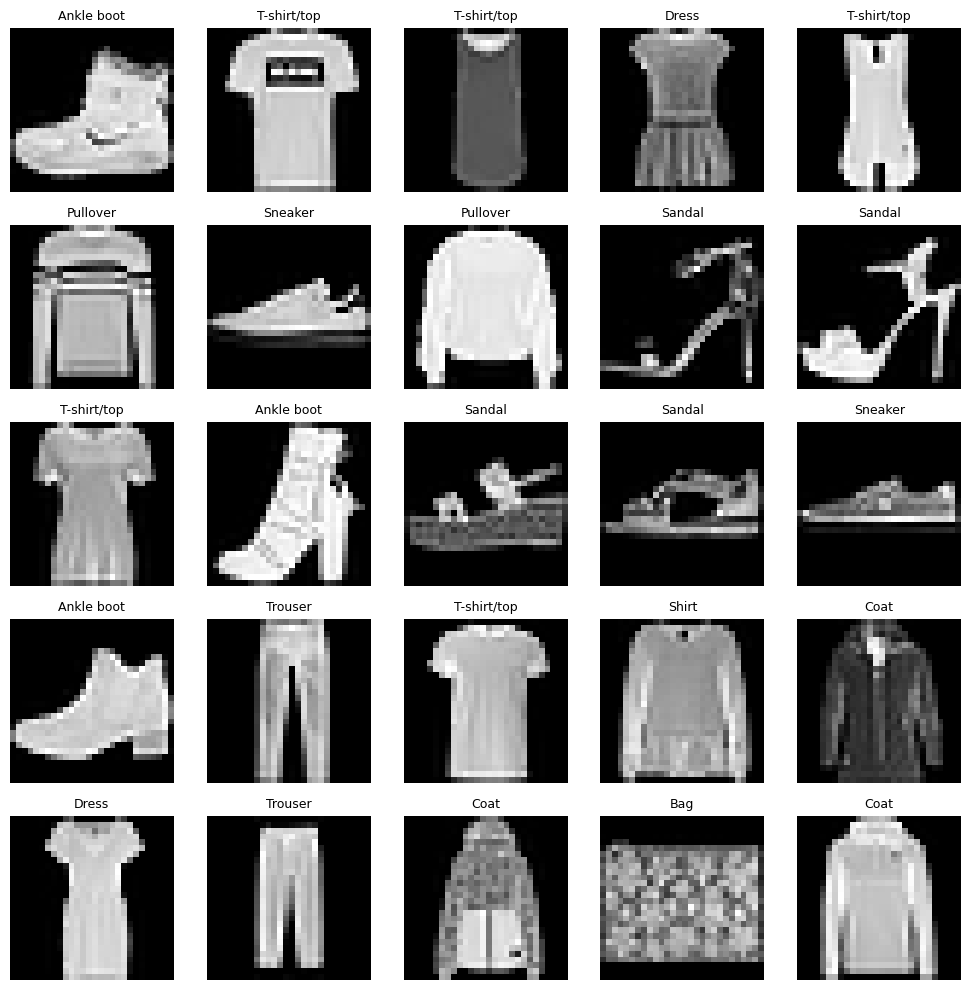

In [26]:
# Define class names (for better understanding)
fashion_mnist_class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Visualize the images

num_images = 25

# สร้างกราฟ 5x5
plt.figure(figsize=(10,10))
for i in range(num_images):
    plt.subplot(5, 5, i + 1)
    plt.imshow(fm_X_train[i], cmap='gray')
    plt.title(fashion_mnist_class_names[fm_y_train[i]], fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()

### **Exercise 2: Preprocessing Images (Flatten and Scale)**

Images are 2D arrays (matrices of pixels) and pixel values are integers from 0-255. For Logistic Regression, we need:
*  **Flattening:** Convert each 28x28 image into a 1D array of 784 features.
*  **Scaling:** Normalize pixel values from [0, 255] to [0, 1].

**Instructions:**

1.   **Flatten:** Use the `.reshape()` method (see [documentation](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.reshape.html)). For `fm_X_train_binary` (shape `(num_samples, 28, 28)`), you want to reshape it to `(num_samples, 28*28)`.
2.  **Scale:** Divide the flattened pixel values by 255.0 to get values between 0 and 1.
3.   **Train Logistic Regression:**
    *   Initialize `LogisticRegression(solver='saga')`. `saga` is a good solver when both number of samples and number of features are large.
    *   Fit the model on your *processed* `fm_X_train_scaled` and `fm_y_train`.
4.   **Make Predictions:** Use `predict()` to make predictions on the *processed* `fm_X_test_scaled`.
5.   **Print Classification Report:** Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?
6.   **Visualize Misclassifications:**
    *   Find the indices in `fm_X_test_binary` where your model made incorrect predictions (i.e., `fm_y_pred != fm_y_test`).
    *   Select 5 of these misclassified images.
    *   Plot these images (using `plt.imshow`). For each image, print its true label and its predicted label.

In [27]:
# Flattening
fm_X_train_binary = fm_X_train.reshape(fm_X_train.shape[0], 28*28)
fm_X_test_binary = fm_X_test.reshape(fm_X_test.shape[0], 28*28)

# Scale
fm_X_train_scaled = fm_X_train_binary / 255.0
fm_X_test_scaled = fm_X_test_binary / 255.0

In [57]:
# Train Logistic Regression

model = LogisticRegression(solver='saga')
model.fit(fm_X_train_scaled, fm_y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(solver='saga')

In [63]:
# Make Predictions
fm_y_pred = model.predict(fm_X_test_scaled)

In [64]:
# Print Classification Report
print(classification_report(fm_y_test, fm_y_pred, target_names=fashion_mnist_class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.80      0.80      0.80      1000
     Trouser       0.97      0.96      0.96      1000
    Pullover       0.73      0.74      0.73      1000
       Dress       0.83      0.86      0.85      1000
        Coat       0.74      0.76      0.75      1000
      Sandal       0.95      0.92      0.93      1000
       Shirt       0.63      0.57      0.60      1000
     Sneaker       0.91      0.94      0.92      1000
         Bag       0.93      0.94      0.93      1000
  Ankle boot       0.95      0.94      0.95      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



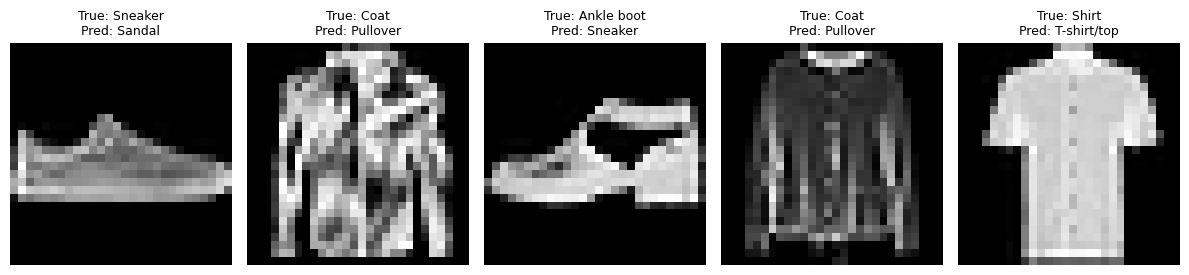

In [68]:
# Visualize Misclassifications
import numpy as np
import matplotlib.pyplot as plt

# หา index ที่ทำนายผิด
misclassified_indices = np.where(fm_y_pred != fm_y_test)[0]

# เลือก 5 ตัวอย่าง
selected_indices = misclassified_indices[:5]

# แสดงภาพ
plt.figure(figsize=(12, 6))
for i, idx in enumerate(selected_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(fm_X_test_binary[idx].reshape(28, 28), cmap='gray')
    true_label = fashion_mnist_class_names[fm_y_test[idx]]
    predicted_label = fashion_mnist_class_names[fm_y_pred[idx]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Part 3: 20 Newsgroups Dataset - Text Classification

### Load 20 Newsgroups Dataset

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics.

In [72]:
# Load the training and testing data
news_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
news_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42)

X_train_news, y_train_news = news_train.data, news_train.target
X_test_news, y_test_news = news_test.data, news_test.target

print(f"Number of training documents: {len(X_train_news)}")
print(f"Number of test documents: {len(X_test_news)}")
print(f"Categories: {news_train.target_names}")

Number of training documents: 11314
Number of test documents: 7532
Categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


### Explore Sample Document

In [77]:
# Print the first document and its class

news_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
X_train_news, y_train_news = news_train.data, news_train.target
target_names = news_train.target_names

# Create DataFrame for exploration
df_news = pd.DataFrame({
    'text': X_train_news,
    'target': y_train_news
})

# Map numeric labels to category names
df_news['category'] = df_news['target'].map(lambda x: target_names[x])

# --- Check for missing values ---
print("\nMissing Values Count")
print(df_news.isnull().sum())

# --- Check unique values for categorical column (category) ---
print("\nCategory Counts")
print(df_news['category'].value_counts())

# --- Check basic statistics about the documents ---
print("\nText Length Stats (in characters)")
df_news['text_length'] = df_news['text'].apply(len)
print(df_news['text_length'].describe())


Missing Values Count
text        0
target      0
category    0
dtype: int64

Category Counts
category
rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
sci.med                     594
rec.autos                   594
sci.space                   593
comp.windows.x              593
comp.os.ms-windows.misc     591
sci.electronics             591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: count, dtype: int64

Text Length Stats (in characters)
count    11314.000000
mean      1949.310058
std       4159.979767
min        125.000000
25%        753.250000
50%       1178.000000
75%       1881.000000
max      75154.000000
Name: text_length, d

### Preprocessing: Text Vectorization Demonstration with `TfidfVectorizer`

$$
\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$

Where:

$$
\text{TF}(t, d) = \frac{\text{number of word }t\text{ in } d}{\text{number of words in } d} \quad \text{ and } \quad
\text{IDF}(t, D) = \log\left(\frac{\text{total number of documents}}{\text{number of documents that contain word }t}\right).
$$

In [79]:
# Create a small list of sentences for demonstration
sample_sentences = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?"
]

# Initialize TfidfVectorizer for demonstration
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the sample sentences
# The output `sample_vec_output` will be a sparse matrix
sample_vec_output_sparse = vectorizer.fit_transform(sample_sentences)

# Convert to a dense NumPy array for easier viewing
sample_vec_output_dense = sample_vec_output_sparse.toarray()

print("\nVocabulary (word to index mapping):")
print(vectorizer.vocabulary_)

print("\nFeature names (words):")
print(vectorizer.get_feature_names_out())

print("\nTF-IDF matrix for sample sentences (dense format):")
print(sample_vec_output_dense)


Vocabulary (word to index mapping):
{'document': 0, 'second': 1}

Feature names (words):
['document' 'second']

TF-IDF matrix for sample sentences (dense format):
[[1.         0.        ]
 [0.78722298 0.61666846]
 [0.         0.        ]
 [1.         0.        ]]


### **Exercise 3: Apply TF-IDF Vectorization to Full Dataset**

Now, apply `TfidfVectorizer` to the actual training and testing datasets for the 20 Newsgroups classification task.

**Instructions:**

1.  **Initialize `TfidfVectorizer`:**
    *   Initialize `TfidfVectorizer`. Use `stop_words='english'` to remove common words.
2.  **Fit and Transform Training Data:**
    *   Call `fit_transform()` on `X_train_news` to learn the vocabulary and transform the training text into TF-IDF features. Store the result in `X_train_vec`.
3.  **Transform Test Data:**
    *   Call `transform()` on `X_test_news` using the *already fitted* vectorizer. Store the result in `X_test_vec`. **Crucially, do not call `fit_transform()` on the test data!** This would cause data leakage.
4.  **Initialize Logistic Regression:**
    *   Initialize `LogisticRegression(solver='saga')`. `saga` is a good solver when both number of samples and number of features are large.
5.  **Train the Model:**
    *   Fit the model on your `X_train_vec` and `y_train_news`.
6.  **Make Predictions:**
    *   Make predictions using `predict()` on the `X_test_vec`.
7.  **Evaluate the Model:**
    *   Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?

In [88]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Load training and test data
news_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
news_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42)

X_train_news, y_train_news = news_train.data, news_train.target
X_test_news, y_test_news = news_test.data, news_test.target

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform training data
X_train_vec = vectorizer.fit_transform(X_train_news)

# Transform test data (only transform, NOT fit_transform)
X_test_vec = vectorizer.transform(X_test_news)

# Initialize Logistic Regression
model = LogisticRegression(solver='saga', max_iter=1000)

# Train the model
model.fit(X_train_vec, y_train_news)

# Make predictions
y_pred = model.predict(X_test_vec)

# Evaluate the model
print('[ Classification Report ]'.center(75)+'\n')
print(classification_report(y_test_news, y_pred, target_names=news_test.target_names))

                         [ Classification Report ]                         

                          precision    recall  f1-score   support

             alt.atheism       0.79      0.73      0.76       319
           comp.graphics       0.71      0.80      0.75       389
 comp.os.ms-windows.misc       0.75      0.76      0.75       394
comp.sys.ibm.pc.hardware       0.71      0.74      0.72       392
   comp.sys.mac.hardware       0.80      0.83      0.82       385
          comp.windows.x       0.85      0.75      0.79       395
            misc.forsale       0.78      0.87      0.82       390
               rec.autos       0.90      0.89      0.90       396
         rec.motorcycles       0.94      0.95      0.94       398
      rec.sport.baseball       0.88      0.92      0.90       397
        rec.sport.hockey       0.94      0.96      0.95       399
               sci.crypt       0.95      0.91      0.93       396
         sci.electronics       0.75      0.78      0.76       39